In [1]:
import jax
import jax.numpy as jnp
import numpyro
from numpyro import distributions
import flax.linen as nn
from flax.core import freeze
from abc import ABC, abstractmethod
key = jax.random.PRNGKey(0)

In [2]:
def shift_scale(data, scale, shift):
    return (data - shift) / scale


def standardize(data):
    std, mean = jnp.std(data, axis=0), jnp.mean(data, axis=0)
    return shift_scale(data, std, mean)


class Dataset(ABC):
    def __init__(self, data, normalization):
        super().__init__()
        self._data = data
        self._normalization = normalization
        self._std, self._mean = jnp.std(self._data, axis=0), jnp.mean(self._data, axis=0)
        
        if normalization == "standardization":
            self._data = shift_scale(self._data, self._std, self._mean)
        else:
            pass
    
    @abstractmethod
    def __len__(self):
        raise NotImplementedError
    
    @abstractmethod
    def __getitem__(self, index, *args, **kwargs):
        raise NotImplementedError
    
    @property
    def data(self):
        return self._data
    
    @property
    def std(self):
        return self._std

    @property
    def mean(self):
        return self._mean


class ConditionalDataset(Dataset):
    def __init__(self, data, normalization, conditional_indices, dependent_indices):
        self._conditional_indices: List[int] = conditional_indices
        self._dependent_indices: List[int] = dependent_indices
        super().__init__(data=data, normalization=normalization)
    
    def __getitem__(self, index):
        sample = self._data[index]
        conditional = sample[..., self._conditional_indices]
        dependent = sample[..., self._dependent_indices]
        return conditional, dependent
    
    def __len__(self):
        return len(self._data)
    
    @property
    def conditional_indices(self):
        return self._conditional_indices
    
    @property
    def dependent_indices(self):
        return self._dependent_indices


class Sinusoidal(ConditionalDataset):
    def __init__(self, n=150, x_lower=0.0, x_upper=8.0, sigma_noise=0.3, normalization="standardization", rng_key=jax.random.PRNGKey(0)):
        x_key, y_key = jax.random.split(rng_key)
        x = jax.random.uniform(x_key, shape=(n,)) * (x_upper - x_lower)
        noise = jax.random.normal(key=y_key, shape=x.shape) * sigma_noise
        y = jnp.sin(x) + noise
        data = jnp.stack([x, y], axis=-1)
        super().__init__(
            data=data,
            normalization=normalization,
            conditional_indices=[0],
            dependent_indices=[1]
        )


class Regression:
    def __init__(self, transformation, dataset):
        self._transformation = transformation
        self._parameters_prior = distributions.Normal
        self._data_std_prior = distributions.HalfNormal(jnp.ones(1))
        self._outputs_likelihood = distributions.Normal
        self._dataset = dataset
        self._parameters_template = self._transformation.init(jax.random.PRNGKey(0), self._dataset[0][0])

    def __call__(self):
        inputs = self._dataset.data[:, self._dataset.conditional_indices]
        outputs = self._dataset.data[:, self._dataset.dependent_indices]
        
        parameters_dict = {"params": {}}
        for key in self._parameters_template["params"].keys():
            layer = self._parameters_template["params"][key]
            kernel = layer["kernel"]
            bias = layer["bias"]
            parameters_dict["params"][key] = {}
            parameters_dict["params"][key]["kernel"] = numpyro.sample("{}-{}-{}".format("params", key, "kernel"), self._parameters_prior(jnp.zeros(kernel.shape), jnp.ones(kernel.shape)))
            parameters_dict["params"][key]["bias"] = numpyro.sample("{}-{}-{}".format("params", key, "bias"), self._parameters_prior(jnp.zeros(bias.shape), jnp.ones(bias.shape)))
        parameters_dict = freeze(parameters_dict)

        # flatten parameters and make a deterministic variable from it.
        #parameters = numpyro.deterministic("parameters", flax_parameters_dict_to_jax_parameter_vector(parameters_dict))

        means = self._transformation.apply(parameters_dict, inputs)
        #means = self._transformation.apply_from_vector(inputs=inputs, parameters_vector=parameters)
        std = numpyro.sample("std", self._data_std_prior)
        
        with numpyro.plate("data", size=inputs.shape[0], dim=-2):
            return numpyro.sample("outputs", self._outputs_likelihood(means, std), obs=outputs)


In [3]:
# dataset
dataset = Sinusoidal()

In [4]:
# neural network
transformation = nn.Sequential([
    nn.Dense(16),
    nn.tanh,
    nn.Dense(16),
    nn.tanh,
    nn.Dense(1)
])

In [5]:
# prob. regression model
model = Regression(transformation=transformation, dataset=dataset)

In [6]:
# mcmc
def run(rng_key, prob_model, num_warmup, num_samples, progress_bar=False):
    # inference loop
    kernel = numpyro.infer.NUTS(prob_model)
    mcmc = numpyro.infer.MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=1,
        progress_bar=progress_bar,
    )
    mcmc.run(rng_key)
    samples = mcmc.get_samples()
    return samples

In [7]:
samples = run(rng_key=key, prob_model=model, num_warmup=1024, num_samples=1024, progress_bar=True)

sample: 100%|███████████████████████████████| 2048/2048 [00:50<00:00, 40.56it/s, 1023 steps of size 4.64e-03. acc. prob=0.93]


In [8]:
# visualization of some samples
parameters_dicts = []
for i in range(128):
    parameters_dict = {"params": {}}
    for key in samples.keys():
        if key == "std":
            continue

        _, layer, kb = key.split('-')
        if layer not in parameters_dict["params"]:
            parameters_dict["params"][layer] = {}

        # extract ith parameters vector
        parameters_dict["params"][layer][kb] = samples[key][i]
    parameters_dicts.append(parameters_dict)

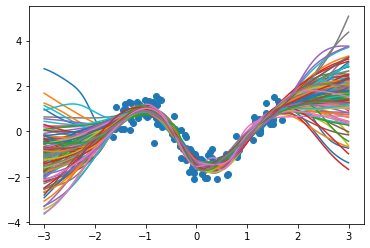

In [9]:
import matplotlib.pyplot as plt
x = jnp.linspace(-3.0, 3.0, 128)
plt.scatter(dataset.data[:, 0], dataset.data[:, 1])
for i in range(len(parameters_dicts)):
    y = transformation.apply(freeze(parameters_dicts[i]), x[:, jnp.newaxis]).squeeze()
    plt.plot(x, y)